#### In this machine learning project, we aim to predict the genre of a movie based on its plot summary using various natural language processing (NLP) techniques and machine learning algorithms. We will leverage techniques like TF-IDF (Term Frequency-Inverse Document Frequency) and classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines (SVM) to build an accurate genre classification model.

# Import nacessary libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Preprocessing
### Load and preprocess data


In [2]:
train_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt'
train_data=pd.read_csv( train_path , sep=':::',engine='python',names=['Title','Genre','Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
test_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt'
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['ID', 'Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [4]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

# Data visualizations

Text(0, 0.5, 'Count')

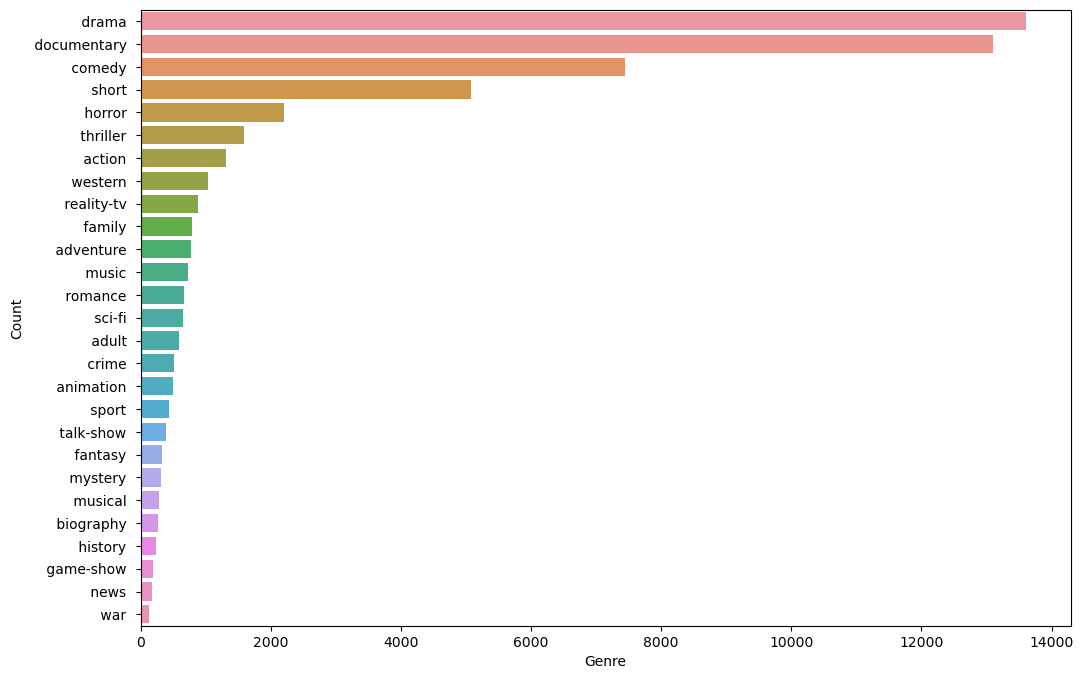

In [7]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts, y=counts.index, orient='h')  
plt.xlabel('Genre')
plt.ylabel('Count')

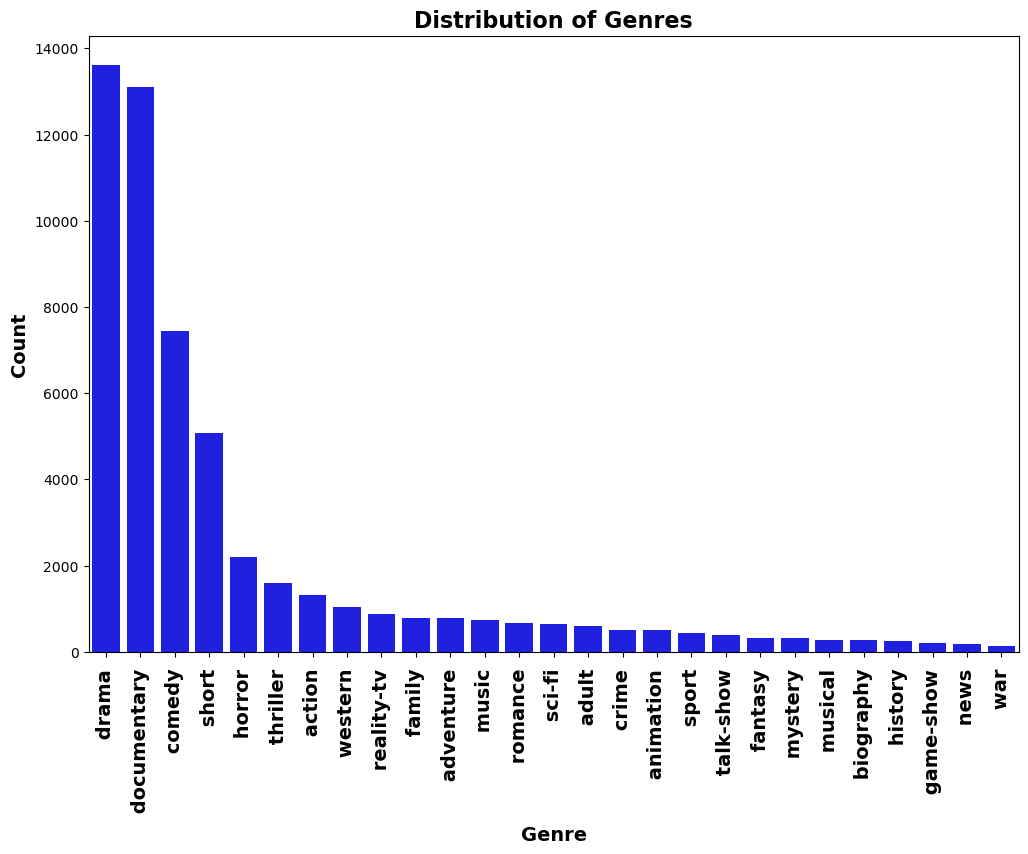

In [8]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts.index, y=counts, color='blue')
plt.xlabel('Genre' ,fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold');

In [9]:
train_data['length']=train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


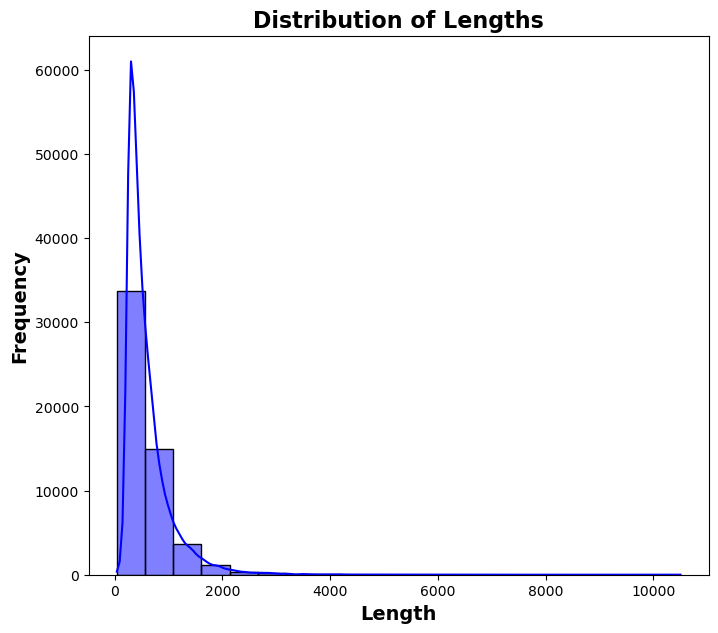

In [10]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

# Data cleaning and preprocessing


In [11]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower()                                  # lower-case all characters
    text = re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = re.sub(f'[{string.digits}]',' ',text)  # remove digits
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # remove stopwords and stem other words
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations


# Test your cleaning function
input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text: {input_text}')
print(f'Cleaned text: {clean_text(input_text)}')

Original text: Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text: certain get dram boost hello bye iem


In [12]:
train_data['Text_cleaning'] = train_data.Description.apply(clean_text)
test_data['Text_cleaning'] = test_data.Description.apply(clean_text)

train_data.head()

,Title,Genre,Description,length,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [13]:
train_data['length_Text_cleaning']=train_data['Text_cleaning'].apply(len)
train_data.head()

,Title,Genre,Description,length,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


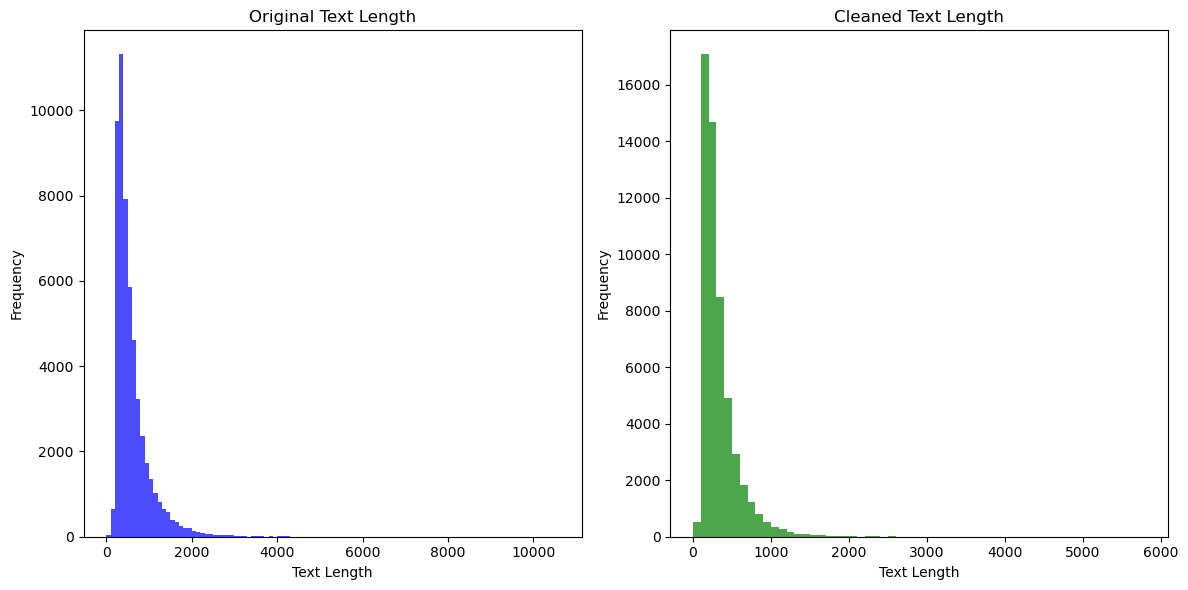

In [14]:
# Create histograms for text length before and after cleaning
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
(train_data['length_Text_cleaning']>2000).value_counts()

False    54131
True        83
Name: length_Text_cleaning, dtype: int64

In [16]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['length_Text_cleaning']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54131
Removed rows: 83


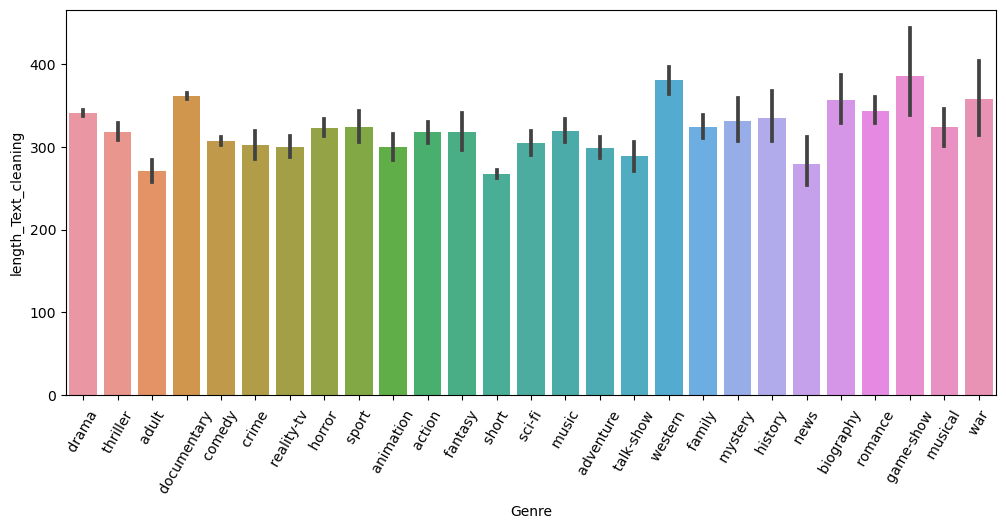

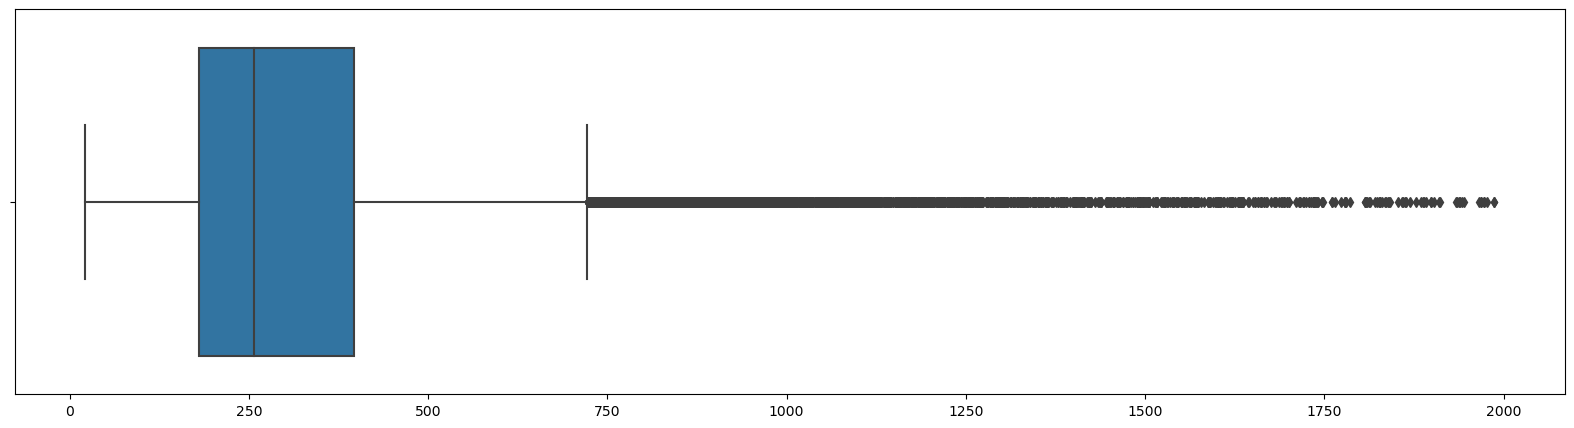

In [17]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre',y='length_Text_cleaning',data=train_data)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data['length_Text_cleaning'].values,hue='Genre',data=train_data)
plt.show()

# Text tokenization and vectorization


In [18]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['Text_cleaning'].values)

In [19]:
test_path='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt'
test_data_solution=pd.read_csv( test_path , sep=':::',engine='python',names=['ID','Title','Genre','Description'])
test_data_solution.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


#  Text Vectorization (TF-IDF)

In [20]:
X = tokenizer.texts_to_sequences(train_data['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_data['Genre']).values

X_test = tokenizer.texts_to_sequences(test_data['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_data_solution['Genre']).values

# Build the LSTM model


In [21]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model


In [22]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

Epoch 1/6
1692/1692 [==============================] - 532s 313ms/step - loss: 1.9974 - accuracy: 0.4199 - val_loss: 1.6832 - val_accuracy: 0.5142
Epoch 2/6
1692/1692 [==============================] - 529s 313ms/step - loss: 1.4605 - accuracy: 0.5768 - val_loss: 1.5448 - val_accuracy: 0.5489
Epoch 3/6
1692/1692 [==============================] - 519s 307ms/step - loss: 1.1305 - accuracy: 0.6727 - val_loss: 1.5738 - val_accuracy: 0.5472
Epoch 4/6
1692/1692 [==============================] - 529s 313ms/step - loss: 0.8539 - accuracy: 0.7519 - val_loss: 1.6869 - val_accuracy: 0.5372


# Plotting Accuracy & Loss

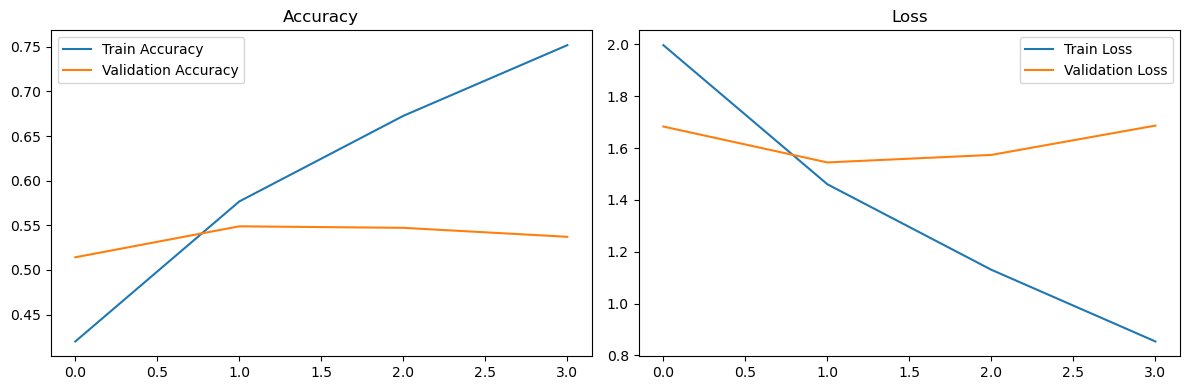

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()